In [1]:
import random
import string

import numpy as np
import pandas as pd
import os
import sys
import subprocess
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()
sns.set_style("white")
sns.despine()
sns.set(rc={'figure.figsize':(16,10)})
plt.style.use('seaborn-whitegrid')

import RNA
from helper import print_moves

<Figure size 432x288 with 0 Axes>

## Search Width Scaling, continued

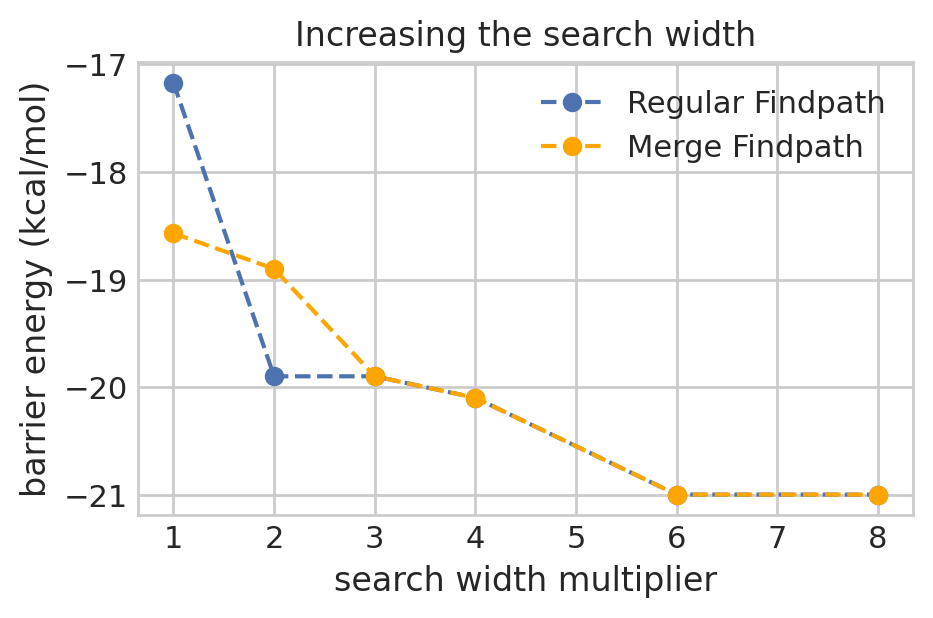

In [2]:
filename = r"sw_scaling_local_min_200x1000_multiple_sections_min10.csv"
prefix = "./results/"
df = pd.read_csv(prefix+filename)


df = df[df["i"]==1]
# df = df[df["i"]==10] # suboptimal paths convergence
# df = df[df["i"]==14]

plt.figure(figsize=(5, 3), dpi=200)

plt.plot(df["search_width_multiplier"], df["new_fp_results"], linestyle='--', marker='o', color='b', label="Regular Findpath")
plt.plot(df["search_width_multiplier"], df["new_merge_results"], linestyle='--', marker='o', color='orange', label="Merge Findpath")
plt.title("Increasing the search width")
plt.xlabel("search width multiplier")
plt.ylabel("barrier energy (kcal/mol)")
plt.legend()

In [45]:
def hist_csv(prefix, filename, barriers=True, subopt_paths=True, limit=14):
    df = pd.read_csv(prefix+filename)
    unique_indices = 100000
    unique = list(df.groupby('i').last().reset_index()["i"])

    search_widths = list(df.groupby('search_width_multiplier').last().reset_index()["search_width_multiplier"])
    search_widths += [0]
    search_widths.sort()

    new_fp_hist = []
    new_fp_merge_hist = []
    old_fp_merge_hist = []

    errors = []

    new_fp_above_2 = 0
    new_fp_merge_above_2 = 0
    old_fp_merge_above_2 = 0

    new_fp_below_2 = 0
    new_fp_merge_below_2 = 0
    old_fp_merge_below_2 = 0

    new_fp_error = []
    new_fp_merge_error = []
    old_fp_merge_error = []

    for i in range(unique_indices):
        if i not in unique:
            continue

        if barriers:
            # max_en from barriers result
            max_en = df.loc[df['i'] == i, 'barriers_max_en'].min()
        else:
            # max_en without barriers result
            max1 = df.loc[df['i'] == i, 'new_fp_results'].min()
            max2 = df.loc[df['i'] == i, 'new_merge_results'].min()
            max_en = min(max1, max2)

        # when do we reach max_en?
        try:
            sw1 = df[(df['new_fp_results'] == max_en) & (df['i'] == i)].iloc[0]["search_width_multiplier"]
        except:
            errors.append((i, "single findpath", max_en))
            new_fp_error.append(i)
            sw1 = 0
        new_fp_hist.append(sw1)

        if sw1 > 2:
            new_fp_above_2 += 1
        if sw1 <= 2 and sw1 >0:
            new_fp_below_2 += 1

        try:
            sw2 = df[(df['new_merge_results'] == max_en) & (df['i'] == i)].iloc[0]["search_width_multiplier"]
        except:
            errors.append((i, "merge findpath", max_en))
            new_fp_merge_error.append(i)
            sw2 = 0
        new_fp_merge_hist.append(sw2)

        if sw2 > 2:
            new_fp_merge_above_2 += 1
        if sw2 <= 2 and sw2 >0:
            new_fp_merge_below_2 += 1


        try:
            sw3 = df[(df['old_merge_results'] == max_en) & (df['i'] == i)].iloc[0]["search_width_multiplier"]
        except:
            errors.append((i, "old merge findpath", max_en))
            old_fp_merge_error.append(i)
            sw3 = 0
        old_fp_merge_hist.append(sw3)

        if sw3 > 2:
            old_fp_merge_above_2 += 1
        if sw3 <= 2 and sw3 >0:
            old_fp_merge_below_2 += 1

    # plot
    hist_df1 = pd.DataFrame(new_fp_hist, columns=["search width multiplier"])
    hist_df1["method"] = "single findpath"
    hist_df2 = pd.DataFrame(new_fp_merge_hist, columns=["search width multiplier"])
    hist_df2["method"] = "merge findpath"
    hist_df3 = pd.DataFrame(old_fp_merge_hist, columns=["search width multiplier"])
    hist_df3["method"] = "merge findpath with subopt paths"

    if subopt_paths:
        hist_df = pd.concat([hist_df1, hist_df2, hist_df3])
    else:
        hist_df = pd.concat([hist_df1, hist_df2])

    # sns.histplot(x=0, data=hist_df, bins=np.arange(0,max(search_widths)), hue="method", multiple="dodge", binwidth=0.4)
    sns.histplot(x="search width multiplier", data=hist_df, bins=np.arange(0,max(search_widths)), hue="method", multiple="dodge", discrete=True, shrink=0.6)

    plt.title("Histogram: Method Convergence")
    plt.xlim((-1,limit))

    # return new_fp_above_2, new_fp_error, new_fp_merge_above_2, new_fp_merge_error, old_fp_merge_above_2, old_fp_merge_error, len(unique)
    return new_fp_below_2, new_fp_error, new_fp_merge_below_2, new_fp_merge_error, old_fp_merge_below_2, old_fp_merge_error, len(unique)


## Findpath convergence (vs barriers direct)

datasets:

100 nt * 1000

150 nt * 300

200 nt * 200

dataset size: 302
single findpath, convergence until search width m. = 2: 276 / 91.39%
single findpath, no convergence:                        1 [155]
merge findpath, convergence until search width m. = 2:  298 / 98.68%
merge findpath, no convergence:                         1 [155]
merge findpath + subopt paths, convergence -> 2:        295 / 97.68%
merge findpath + subopt paths, no convergence:          3 [25, 155, 240]



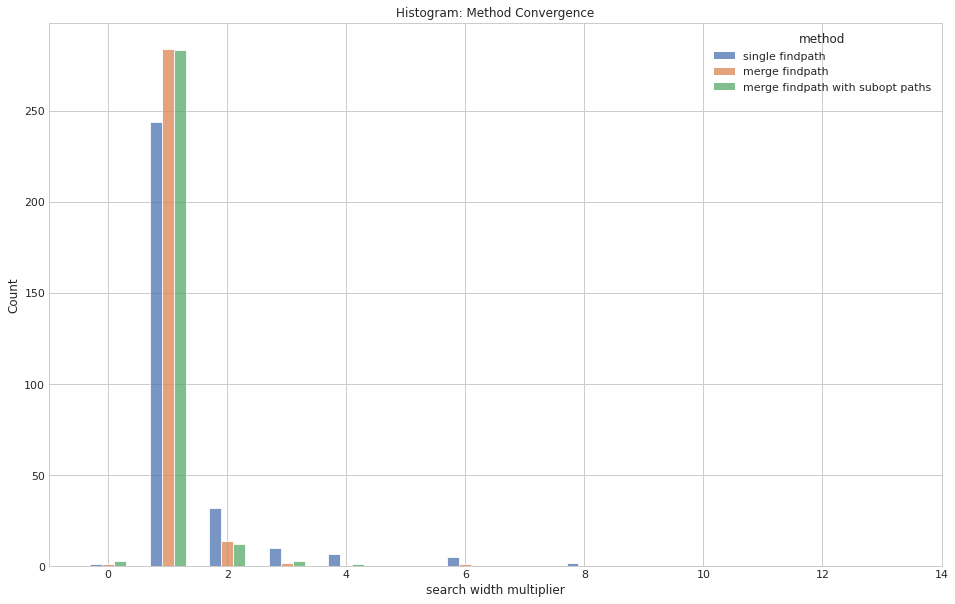

In [54]:
prefix = "./results/"
# filename = "sw_scaling_1000x_200-30.csv" 
filename = "sw_scaling_1000x_150-25.csv"
# filename = "sw_scaling_1000x_100-20.csv"

limit = 14

new_fp_above_2, new_fp_error, new_fp_merge_above_2,\
     new_fp_merge_error, old_fp_merge_above_2, old_fp_merge_error,\
          unique_indices = hist_csv(prefix, filename, barriers=True, limit=limit)

# new_fp_above_2, new_fp_error, new_fp_merge_above_2,\
#      new_fp_merge_error, old_fp_merge_above_2, old_fp_merge_error,\
#           unique_indices = hist_csv(prefix, filename, barriers=False, limit=limit)

print ("dataset size:", unique_indices)
print (f"single findpath, convergence until search width m. = 2: {new_fp_above_2} / {new_fp_above_2/unique_indices*100:2.2f}%")
print (f"single findpath, no convergence:                        {len(new_fp_error)} {new_fp_error}")
print (f"merge findpath, convergence until search width m. = 2:  {new_fp_merge_above_2} / {new_fp_merge_above_2/unique_indices*100:2.2f}%")
print (f"merge findpath, no convergence:                         {len(new_fp_merge_error)} {new_fp_merge_error}")
print (f"merge findpath + subopt paths, convergence -> 2:        {old_fp_merge_above_2} / {old_fp_merge_above_2/unique_indices*100:2.2f}%")
print (f"merge findpath + subopt paths, no convergence:          {len(old_fp_merge_error)} {old_fp_merge_error}")
print ()

## Example paths "barriers direct"

In [5]:
# barriers direct and "indirect paths"...

# ex for "indirect path"
filename = "sw_scaling_1000x_100-20.csv"
i = 293

# subopt results required...
# filename = "sw_scaling_1000x_200-30.csv" 
# i = 348
# i = 386

df = pd.read_csv(prefix+filename)

print (i, "regular findpath:", df[df["i"]==i]["new_fp_results"].iloc[0])
print (i, "merge  findpath:", df[df["i"]==i]["new_merge_results"].iloc[0])
print (i, "o. merge  findpath:", df[df["i"]==i]["old_merge_results"].iloc[0])
print (i, "barriers direct:", df[df["i"]==i]["barriers_max_en"].iloc[0])

sequence = df[df["i"]==i]["sequence"].iloc[0]
s1 = df[df["i"]==i]["s1"].iloc[0]
s2 = df[df["i"]==i]["s2"].iloc[0]
moves = df[df["i"]==i]["moves"].iloc[0]
moves = list(eval(moves))

if df[df["i"]==i]["barriers_max_en"].iloc[0] != 0:
    print_moves(sequence, s1, s2, moves)

293 regular findpath: -6.1
293 merge  findpath: -6.1
293 o. merge  findpath: -6.1
293 barriers direct: -6.6
UCAACGGUUUUAUUGAAUCCUGCAACCGUCAACGAUUGACCGAACCGAGCCGAGGGGACAUCCGGACAACUUAAACUGCAUGGGCCCGAUUAAGAGAUAA
....((((((...(.((((.(((....).))..)))).)..))))))......(((..(((.(((..........))).)))..)))............. [   0,    0 ] -15.90
....((((((.....((((.(((....).))..))))....))))))......(((..(((.(((..........))).)))..)))............. [ -14,  -39 ] -15.80
....((((((......(((.(((....).))..))).....))))))......(((..(((.(((..........))).)))..)))............. [ -16,  -37 ] -13.70
....((((((.......((.(((....).))..))......))))))......(((..(((.(((..........))).)))..)))............. [ -17,  -36 ] -12.40
....((((((........(.(((....).))..).......))))))......(((..(((.(((..........))).)))..)))............. [ -18,  -35 ] -10.60
....((((((..........(((....).))..........))))))......(((..(((.(((..........))).)))..)))............. [ -19,  -34 ] -13.10
....((((((...........((....).)...........))))))......(((..(

## Barrier shift regular Findpath vs. merging Findpath at given sw.

sum deviations: -8.900000000000013


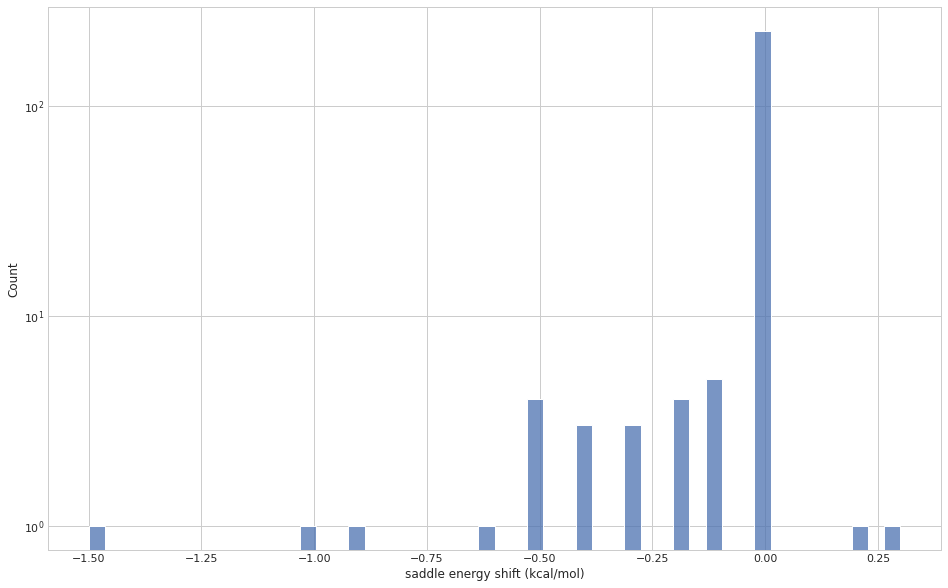

In [42]:

prefix = "./results/"
filename = "sw_scaling_1000x_200-30.csv" 
# filename = "sw_scaling_1000x_150-25.csv"
# filename = "sw_scaling_1000x_100-20.csv"


swm = 2

df_s = pd.read_csv(prefix+filename)
df_s = df_s[df_s["search_width_multiplier"]==swm]

differences = df_s["new_merge_results"] - df_s["new_fp_results"] # vs regular findpath
# differences = df_s["old_merge_results"] - df_s["new_fp_results"] # vs regular findpath
# differences = df_s["old_merge_results"] - df_s["new_merge_results"]


sns.histplot(differences, bins=50)
plt.yscale('log',base=10) 
plt.xlabel("saddle energy shift (kcal/mol)")

print ("sum deviations:", sum(differences))

## Convergence for larger sequences

dataset size: 1000
single findpath, convergence until search width m. = 2: 400 / 40.00%
merge findpath, convergence until search width m. = 2:  690 / 69.00%



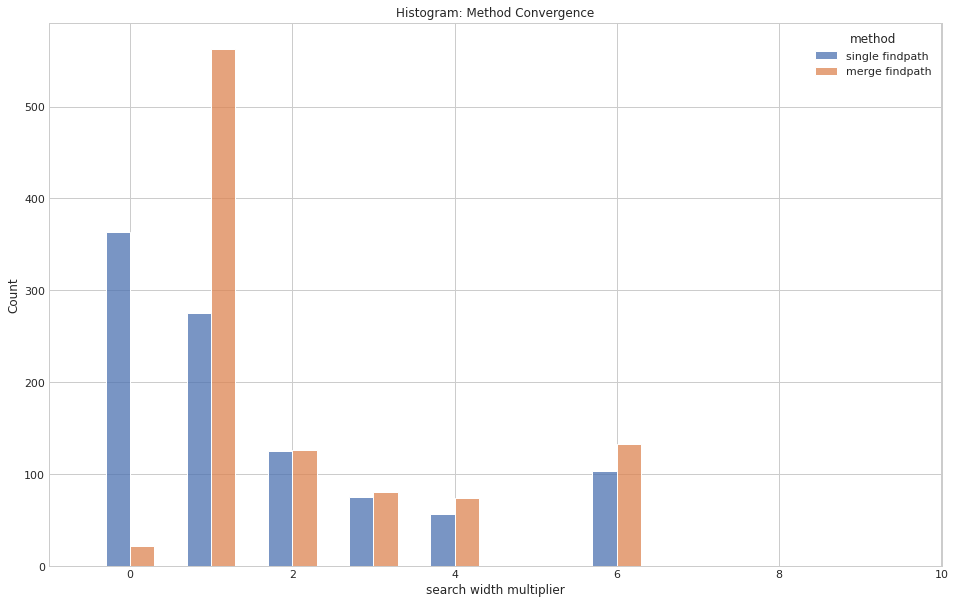

In [47]:
# datasets without barriers results (larger distances...)

prefix = "./results/"
limit = 10


# filename = "sw_scaling_local_min_100x1000_multiple_sections_min10.csv"
# filename = "sw_scaling_local_min_200x1000_multiple_sections_min10.csv"
filename = "sw_scaling_local_min_300x1000_multiple_sections_min10.csv"

new_fp_above_2, new_fp_error, new_fp_merge_above_2, new_fp_merge_error, old_fp_merge_above_2, old_fp_merge_error, unique_indices = hist_csv(prefix, filename, barriers=False, subopt_paths=False, limit=limit)
print ("dataset size:", unique_indices)
print (f"single findpath, convergence until search width m. = 2: {new_fp_above_2} / {new_fp_above_2/unique_indices*100:2.2f}%")
print (f"merge findpath, convergence until search width m. = 2:  {new_fp_merge_above_2} / {new_fp_merge_above_2/unique_indices*100:2.2f}%")
print ()


## Findpath Variations


### Reference: random 600 nt sequence

#### Initial modifications: Multiple output paths, compute always final fwd+bwd passes, multithreading (fwd+bwd parallel)
    
    Current structures (search width) -> next candidate structures (search width * moves):
        loop tables calc / energy calculation / memory allocation (malloc) / memcpy
        -> sort unique (memcmp with short*) -> sort en -> ...
    + postprocessing for merging

slower runtime than original (no LTO) > 2 s

#### modification 1: strings instead of pairing tables, memory allocation at start
    
    Current structures (search width) -> next candidate structures (search width * moves):
        pairing tables & loop tables calc (no malloc) / energy calculation / memcpy
        -> sort unique (memcmp with char*) -> sort en -> ...
    no malloc/free during d=0 -> d=dist

~ 1.3 s

#### modification 2: faster quicksort (structures hashes with std::hash & std::string_view of C++17)

    Current structures (search width) -> next candidate structures (search width * moves):
        pairing tables & loop tables calc (no malloc) / energy calculation / structure -> hash
        -> sort unique with uint_64t hash values -> sort en -> memcpy -> ...

0.6-0.7 s (no memcmp!)

#### modification 3: precomputed hash values (move tuples (i,j) as hash input & mixing function / integer hashing)

```
    Initial structure: hash 0
    moves: 

    (-5, -15) ->  7421083294200245103
    (-6, -14) ->  3012207679026547530
    (-7, -13) -> 11446475957418504593
    
    (-5, -15) + (-6, -14) has to yield identical hash as
    (-6, -14) + (-5, -15)
    

    final hash: 1280487199884801529
```

0.5 s 

#### in related news...

using std::unordered_map instead of std::quicksort / sort unique

\> 1.5 s

other sort algorithms are not faster than quicksort

### Precomputed tuple hashes (Python variant) below:


In [47]:
# vgl, hashing @ barriers?

def int_hash_64(x):
    z = np.uint64((x + 0x9e3779b97f4a7c15))
    z          = (z ^ (z >> np.uint64(30))) * 0xbf58476d1ce4e5b9
    z          = (z ^ (z >> np.uint64(27))) * 0x94d049bb133111eb
    return z ^ (z >> np.uint64(31))

sequence = "UGAAGACCCAUUGAGUAAAA"
s1       = "(((((((.....)))).)))"
s2       = "((((...........).)))"
# s1       = "..(((((.....)))).).."
# s2       = "..((...........).).."
# s1       = "(((((((.....)))).)))"
# s2       = "(((..............)))"

pt1 = RNA.ptable(s1)
pt2 = RNA.ptable(s2)

move_list = []
h_list = []
final_h = int_hash_64(0)
bp_dist = 0

# find all direct moves
for i in range(1, pt1[0]):
    if (pt1[i] != pt2[i]):
        if (i < pt1[i]):
            # delete this pair
            h = int_hash_64(-i)
            h += int_hash_64(-pt1[i])
            h += int_hash_64(i*(-pt1[i]))
            move_list.append((-i, -pt1[i], h))
            h_list.append(np.uint64(h))
            final_h += h
            bp_dist += 1
        
        if (i < pt2[i]): 
            # insert this pair
            h = int_hash_64(i)
            h += int_hash_64(pt2[i])
            h += int_hash_64(i*pt2[i])
            move_list.append((i, pt2[i], h))            
            h_list.append(np.uint64(h))
            final_h += h
            bp_dist += 1

for i,j, hashvalue in move_list:
    print ((i,j), "->", hashvalue)
print (f"final hash: {final_h}")

(-5, -15) -> 7421083294200245103
(-6, -14) -> 3012207679026547530
(-7, -13) -> 11446475957418504593
final hash: 1280487199884801529


<ipython-input-47-ca88af656168>:32: RuntimeWarning: overflow encountered in ulonglong_scalars
  h += int_hash_64(i*(-pt1[i]))
<ipython-input-47-ca88af656168>:35: RuntimeWarning: overflow encountered in ulonglong_scalars
  final_h += h
<ipython-input-47-ca88af656168>:31: RuntimeWarning: overflow encountered in ulonglong_scalars
  h += int_hash_64(-pt1[i])


### different hashes -> different results

    quicksort compare function
    
``` C
single_findpath::compare_ptable(const void* A, const void* B) -> int
{
    intermediate_t *a, *b;
    int             c;
    a = (intermediate_t*)A;
    b = (intermediate_t*)B;

    c = memcmp(a->s, b->s, a->length * sizeof(char));
    if (c != 0) 
        return -c;

    if ((a->saddle_en - b->saddle_en) != 0)
        return a->saddle_en - b->saddle_en;

    return a->curr_en - b->curr_en;
}
```

    sort unique:
    (((((((.....)))).))) saddle: 2 kcal/mol
    (((((((.....)))).))) saddle: 3 kcal/mol
    (((((((.....)))).))) saddle: 4 kcal/mol
    ((((((.......))).))) saddle: 1 kcal/mol
    ((((((.......))).))) saddle: 1.5 kcal/mol
    ((((((.......))).))) saddle: 2 kcal/mol
    (((((.........)).))) saddle: 1 kcal/mol
    (((((.........)).))) saddle: 2 kcal/mol
    (((((.........)).))) saddle: 4 kcal/mol

    after sort unique:
    (((((((.....)))).))) saddle: 2 kcal/mol
    ((((((.......))).))) saddle: 1 kcal/mol
    (((((.........)).))) saddle: 1 kcal/mol

    reduce to search width (2):
    (((((((.....)))).))) saddle: 2 kcal/mol
    ((((((.......))).))) saddle: 1 kcal/mol

    vs:
    (((((((.....)))).))) saddle: 2 kcal/mol
    (((((.........)).))) saddle: 1 kcal/mol

eliminate 1 kcal/mol structures?


## Barrier shift w & w/o hashing

sum deviations: -14.030000000000005


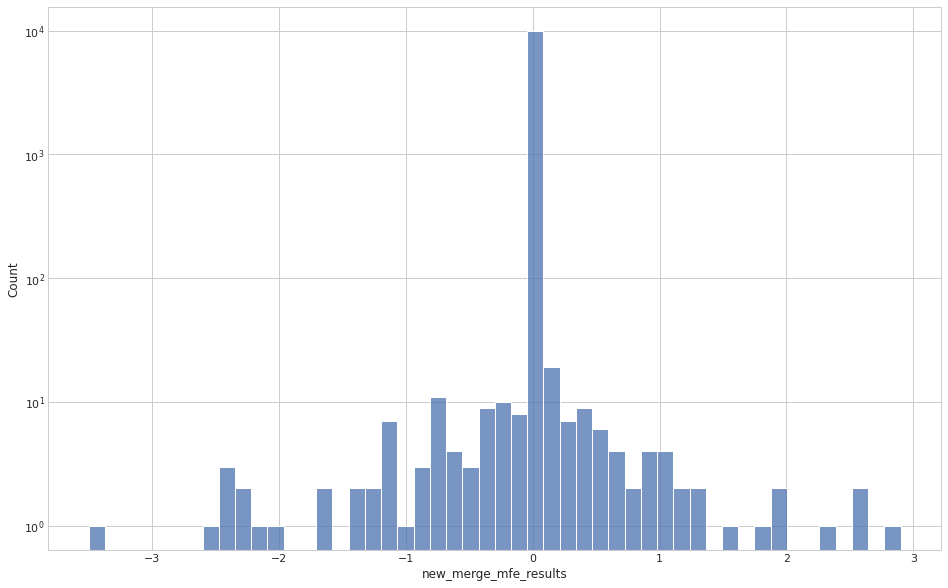

In [106]:
# dataset with 10,000 sequences

prefix = "./results/"
filename = ["l_hash2_local_min_100x10000_multiple_sections_min10.csv",
             "l_nohash_local_min_100x10000_multiple_sections_min10.csv"]

a_df = pd.read_csv(prefix+filename[0])
b_df = pd.read_csv(prefix+filename[1])

differences = a_df["new_merge_mfe_results"] - b_df["new_merge_mfe_results"]

sns.histplot(differences, bins=50)        
plt.yscale('log',base=10) 
print ("sum deviations:", sum(differences))

## Convergence tests with / without hashing


dataset size: 1000
single findpath, convergence until search width m. = 2: 608 / 60.80%
merge findpath, convergence until search width m. = 2:  742 / 74.20%



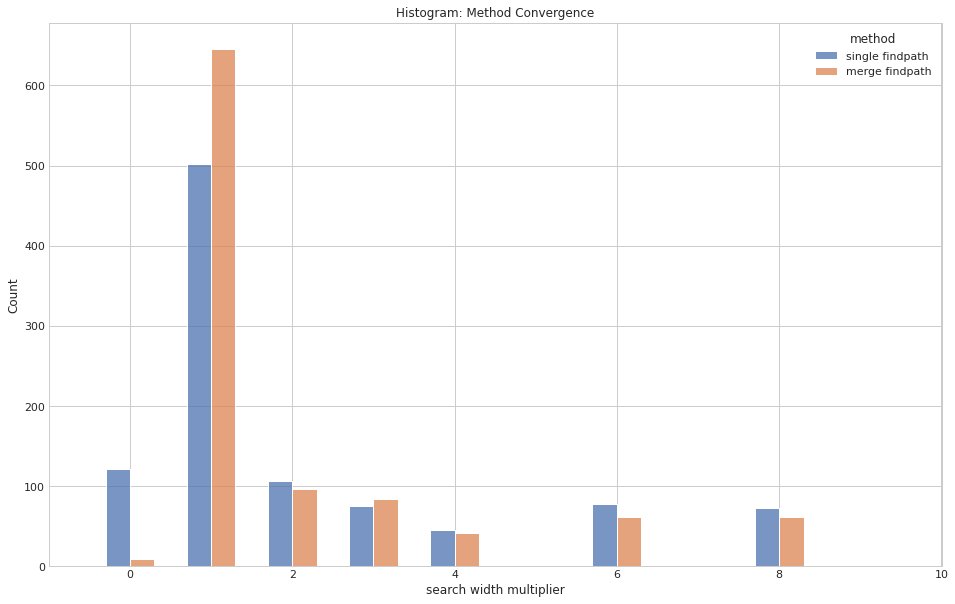

In [53]:
# Convergence tests without hashing

prefix = "./results/"
limit = 10

# filename = "sw_scaling_local_min_100x1000_multiple_sections_min10.csv"
filename = "sw_scaling_local_min_200x1000_multiple_sections_min10.csv"

new_fp_above_2, new_fp_error, new_fp_merge_above_2, new_fp_merge_error, old_fp_merge_above_2, old_fp_merge_error, unique_indices = hist_csv(prefix, filename, barriers=False, subopt_paths=False, limit=limit)
print ("dataset size:", unique_indices)
print (f"single findpath, convergence until search width m. = 2: {new_fp_above_2} / {new_fp_above_2/unique_indices*100:2.2f}%")
print (f"merge findpath, convergence until search width m. = 2:  {new_fp_merge_above_2} / {new_fp_merge_above_2/unique_indices*100:2.2f}%")
print ()

dataset size: 1000
single findpath, convergence until search width m. = 2: 609 / 60.90%
merge findpath, convergence until search width m. = 2:  750 / 75.00%



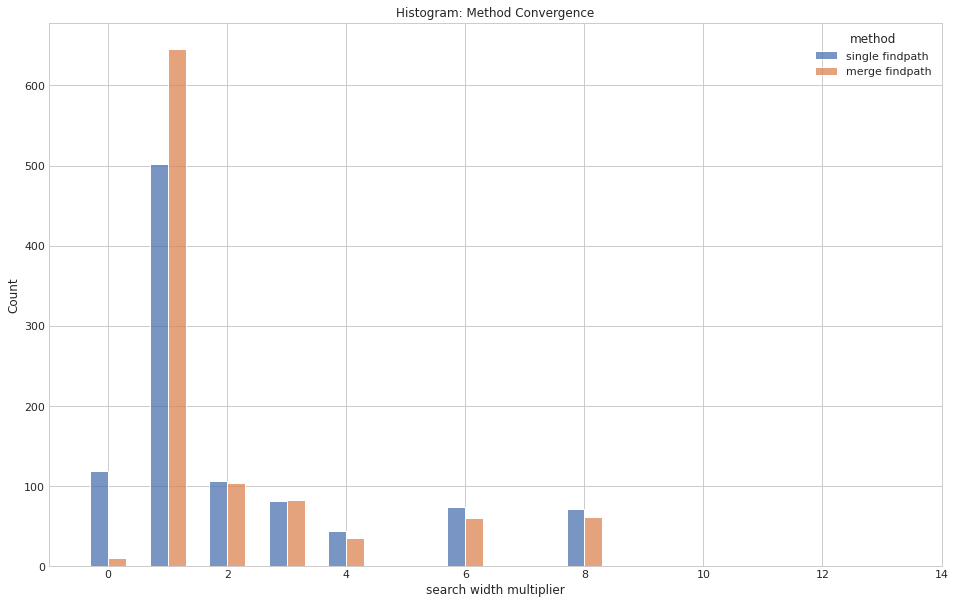

In [52]:
# with hashing

# filename = "sw_scaling_fasthash_local_min_100x1000_multiple_sections_min10.csv"
filename = "sw_scaling_fasthash_local_min_200x1000_multiple_sections_min10.csv"

new_fp_above_2, new_fp_error, new_fp_merge_above_2, new_fp_merge_error, old_fp_merge_above_2, old_fp_merge_error, unique_indices = hist_csv(prefix, filename, barriers=False, subopt_paths=False, limit=limit)
print ("dataset size:", unique_indices)
print (f"single findpath, convergence until search width m. = 2: {new_fp_above_2} / {new_fp_above_2/unique_indices*100:2.2f}%")
print (f"merge findpath, convergence until search width m. = 2:  {new_fp_merge_above_2} / {new_fp_merge_above_2/unique_indices*100:2.2f}%")
print ()

## latest benchmarks (with hashing)

#### (no suboptimal paths as input)

<AxesSubplot:xlabel='sequence_length', ylabel='runtime'>

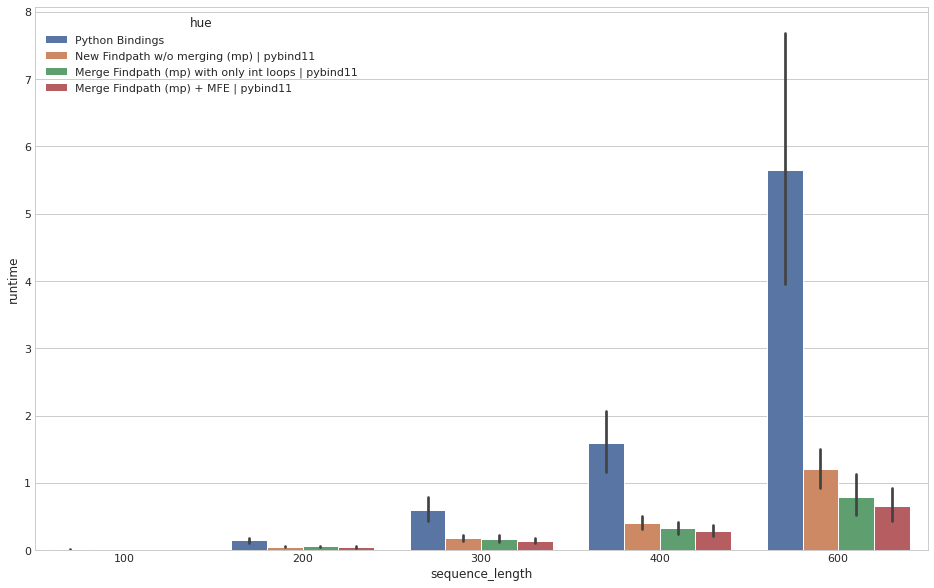

In [14]:
# hashing effect

# barrier shift
prefix = "./results/"
filenames = [
             "n_local_min_100_multiple_sections_min10.csv",
             "n_local_min_200_multiple_sections_min10.csv",
             "n_local_min_300_multiple_sections_min10.csv",
             "n_local_min_400_multiple_sections_min10.csv",
             "n_local_min_600_multiple_sections_min10.csv",
             ]

subplots = len(filenames)

df = pd.DataFrame()

for i, filename in enumerate(filenames):
    c_df = pd.read_csv(prefix+filename)
    frames = [df, c_df]
    c_df["sequence_length"] = len(c_df["sequence"][0])
    c_df["runtime"] = c_df["py_runtimes"]
    c_df["hue"] = "Python Bindings"    
    df = pd.concat(frames)    

    # c_df = pd.read_csv(prefix+filename)
    # frames = [df, c_df]
    # c_df["sequence_length"] = len(c_df["sequence"][0])
    # c_df["runtime"] = c_df["new_fp_runtimes"]
    # c_df["hue"] = "New Findpath w/o merging (single thread) | pybind11" 
    # df = pd.concat(frames)    
    
    c_df = pd.read_csv(prefix+filename)
    frames = [df, c_df]
    c_df["sequence_length"] = len(c_df["sequence"][0])
    c_df["runtime"] = c_df["new_fp_runtimes"]
    c_df["hue"] = "New Findpath w/o merging (mp) | pybind11" 
    df = pd.concat(frames)    
    
    c_df = pd.read_csv(prefix+filename)
    frames = [df, c_df]
    c_df["sequence_length"] = len(c_df["sequence"][0])
    c_df["runtime"] = c_df["new_merge_runtimes"]
    c_df["hue"] = "Merge Findpath (mp) with only int loops | pybind11" 
    df = pd.concat(frames)    
    
    c_df = pd.read_csv(prefix+filename)
    frames = [df, c_df]
    c_df["sequence_length"] = len(c_df["sequence"][0])
    c_df["runtime"] = c_df["new_merge_mfe_runtimes"]
    c_df["hue"] = "Merge Findpath (mp) + MFE | pybind11" 
    df = pd.concat(frames)    
    
    # c_df = pd.read_csv(prefix+filename)
    # frames = [df, c_df]
    # c_df["sequence_length"] = len(c_df["sequence"][0])
    # c_df["runtime"] = c_df["new_merge_ext_runtimes"]
    # c_df["hue"] = "Merge Findpath (mp) with ext loops | pybind11"    
    # df = pd.concat(frames)   
    

sns.barplot(y="runtime", x="sequence_length", hue="hue", data=df)

## Caching
don't recompute already existing paths

In [60]:
# random 600 nt example
sequence = "AAAAUAAUGUACCGGACAUUCGCGCACGACCACCAUAUGGCAGAGCAUGUGUCUGUGGACCCACUAUAGCUGGGGCGCUUAACCCCAGAAAAGUAUCUUCGGUCUAUGCCUCACACGCAGCCUCCUAUUAGCAGCUCUCCUGGCCCACAAUUUUAUUAAAAGUCCAAGUUGGACUGACAAAACGCGUGCGGUGUCCUAGGGAUUGGUGGCAUAACCAGCGGUUUAAAAGCUGUGUAUAUCCGCAGCAAAUCACCGGAAAGCGGCGUUAUUAGCACCACAAAUUGAUGGUUGGUACGAGUACAAUUGCGCCGCAUAAAACCAGAGAUUCUACCCUCAAUCGGUUCUUAAGACGUACUGCGCGUUUCACCAGACCACAAUGCAGGGCGGCACCGUUAGGCAACACAACGAGACUACUCAUGCACAUAAGGAAGGUUAUCGCCAUAGACAUGGCGCGGCAGCGCAGAAUGUUUAAAUCUAAAUCUGGUAUGGGAGGCGUGCCCGUUGGUAUGAAGAAAUUUGCUGGGAGAAAAAGUCUAAGGCCUUGAAUCCGGCGGGUCUUAAUACUUACCUACAAAAUCAUCAGGCUGUACUUCCUGUAUC"
s1 =       "........(((((((((((((((((..((((.((.((((((((((...((.((((((((((....(((.((((((.......)))))).....)))....))))..(((((...(((..(((((((....(((......((((.................((((((...))))))........((((((((((((.(((((((((((...........((((......((((((......)))))).....))))....(((((((((((.(.((((((......))..)))).).)))).....))))))).........(((........))).))))))))))).)))..)))))))))....)))).......))))))).)))..))).))))).))))..)).))..))).))).)))).))..))))..((((((....)))))).....)))).)))))............))))))))((((((((.(((.(.((((.........((((..(((((.....((.((((((((((....))..)))))))))).))).))..)))))))).).))))))..)))))....."
s2 =       ".............((((((((((((.(((((.((.((((((((((...((.((((((((((...(((..((((((.......))))))....))).....))))..(((((...(((..(((((((....(((......((((.................((((((...))))))........((((((((((((.(((((((((((((.....))..((((......((((((......)))))).....))))....((((((((((((..((((........)))))))))...........))))))).........(((........))).))))))))))).)))..)))))))))....)))).......))))))).)))..))).))))).))))..)).))..))).))).)))).))..)))...((((((....))))))))...)))).))))))))............(((((((((((((.(((.((.(((((.((((..(((((((((.......(((...)))......))))))))))))).))))).))..............)))))..)))))))))))"

sys.path.append('../')
import findpath
# import findpath_librna
import time

search_width_multiplier = 4
mp = False
search_width = RNA.bp_distance(s1, s2)*search_width_multiplier
print ("search width:", search_width, "bp_dist:", RNA.bp_distance(s1, s2), "seq_length:", len(sequence))
fc = RNA.fold_compound(sequence)
s1_eval = fc.eval_structure(s1)
bp_dist = RNA.bp_distance(s1, s2)

# init

fp = findpath.findpath_class(sequence, mp)

search width: 392 bp_dist: 98 seq_length: 600


In [61]:
runtimes = []
for i in range(10):
    start_findpath = time.time()    
    result = fp.init(s1, s2, search_width_multiplier)
    runtime = time.time()-start_findpath
    print (f'{result/100} kcal/mol runtime: {runtime:2.4f} s')    
    runtimes.append(runtime)
print (f'min runtime: {min(runtimes):2.4f} s / total runtime: {sum(runtimes):2.4f}')

-154.0 kcal/mol runtime: 0.1616 s
-154.0 kcal/mol runtime: 0.0011 s
-154.0 kcal/mol runtime: 0.0011 s
-154.0 kcal/mol runtime: 0.0011 s
-154.0 kcal/mol runtime: 0.0012 s
-154.0 kcal/mol runtime: 0.0011 s
-154.0 kcal/mol runtime: 0.0011 s
-154.0 kcal/mol runtime: 0.0011 s
-154.0 kcal/mol runtime: 0.0011 s
-154.0 kcal/mol runtime: 0.0011 s
min runtime: 0.0011 s / total runtime: 0.1717


In [62]:
s1 =       "((......(((((((((((((((((..((((.((.((((((((((...((.((((((((((....(((.((((((.......)))))).....)))....))))..(((((...(((..(((((((....(((......((((.................((((((...))))))........((((((((((((.(((((((((((...........((((......((((((......)))))).....))))....(((((((((((.(.((((((......))..)))).).)))).....))))))).........(((........))).))))))))))).)))..)))))))))....)))).......))))))).)))..))).))))).))))..)).))..))).))).)))).))..))))..((((((....)))))).....)))).)))))............))))))))((((((((.(((.(.((((.........((((..(((((.....((.((((((((((....))..)))))))))).))).))..)))))))).).))))))..)))))...))"

runtimes = []
for i in range(10):
    start_findpath = time.time()    
    result = fp.init(s1, s2, search_width_multiplier)
    runtime = time.time()-start_findpath
    print (f'{result/100} kcal/mol runtime: {runtime:2.4f} s')      
    runtimes.append(runtime)
print (f'min runtime: {min(runtimes):2.4f} s / total runtime: {sum(runtimes):2.4f}')

-154.0 kcal/mol runtime: 0.0536 s
-154.0 kcal/mol runtime: 0.0014 s
-154.0 kcal/mol runtime: 0.0015 s
-154.0 kcal/mol runtime: 0.0012 s
-154.0 kcal/mol runtime: 0.0013 s
-154.0 kcal/mol runtime: 0.0013 s
-154.0 kcal/mol runtime: 0.0012 s
-154.0 kcal/mol runtime: 0.0013 s
-154.0 kcal/mol runtime: 0.0013 s
-154.0 kcal/mol runtime: 0.0013 s
min runtime: 0.0012 s / total runtime: 0.0652


# Indirect Paths

- better neighbour search 
- search width experiments
-- start with low sw, gradually increase sw...
- final search width: not necessarily higher than direct fp

Idea: Find stabilizing structures:
- along the direct path
- common structure (see "mfe" path structure)

In [3]:
import os
os.chdir("../../pathfinder_i")
import pathfinder_i_2
# import merge_composition
os.chdir("../pathfinder/documents/benchmarks")

In [5]:
# rna2dfold example
sequence = "GGGCGCGGUUCGCCCUCCGCUAAAUGCGGAAGAUAAAUUGUGUCU"
s1 = "(((((.....)))))(((((.....)))))(((((.....)))))"
s2 = "((((((((((.....(((((.....))))).....))))))))))"

# sequence = "GGAAGCCGGCGAGGCAGUACCAUUAUAUAGUUUGUCUUCCAAGAAUGGGUACGACCGCGGGACCGUUCGGUUAUCGUCUG"
# s1 = "((.((((((.(((((((.((.........)))))))))))..((((((...((....))...)))))))))).))....."
# s2 = "((.((((((((.((..((((((((....((.....))......))))).)))..)).)).......)))))).))....."

add_moves=[]

section = ()
search_width = 20
Verbose = True
# Debug = True
Debug = False

indirect_iterations = 2

paths = pathfinder_i_2.find_path(sequence, s1, s2, indirect_iterations=indirect_iterations, add_moves=add_moves,
search_width=search_width, Debug=Debug, Verbose=Verbose)

Iteration 0 launching findpath with addtional moves: set()
New best result:  -5.00 kcal/mol | B:  13.10 kcal/mol | E[start]:-18.10 E[end]:-17.70 | additional moves: []
call find_stack for best path
common:
...............(((((.....)))))...............
saddle structure: [0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 30, 29, 28, 27, 26, 0, 0, 0, 0, 0, 20, 19, 18, 17, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
...(.......)...(((((.....)))))...............
s1s2
(((((.....)))))(((((.....)))))(((((.....)))))
((((((((((.....(((((.....))))).....))))))))))
bfs done
Iteration 1 launching findpath with addtional moves: {(6, 12), (3, 14), (2, 15), (7, 11), (5, 13)}
New best result:  -5.80 kcal/mol | B:  12.30 kcal/mol | E[start]:-18.10 E[end]:-17.70 | additional moves: [(6, 12), (7, 11), (5, 13)]
Iteration 1 launching findpath with addtional moves: {(6, 12), (7, 11), (3, 15), (5, 13)}
Iteration 1 launching findpath with addtional moves: {(6, 12), (3, 9), (4, 8), (1, 11), (2, 10), (7, 11),

In [12]:
# 2 alt 1-4
sequence = "GGAAGCCGGCGAGGCAGUACCAUUAUAUAGUUUGUCUUCCAAGAAUGGGUACGACCGCGGGACCGUUCGGUUAUCGUCUG"
s1       = "((.((((((.(((((((.((.........)))))))))))..((((((...((....))...)))))))))).))....."
s2       = "((.((((((((.((..((((((((....((.....))......))))).)))..)).)).......)))))).))....."
s1, s2 = s2, s1

# add_moves = [(10, 65), (11, 64), (14, 58), (15, 57), (49, 63), (50, 62), (48, 64)]
add_moves = []

section = ()
search_width = 64
# search_width = 640
Verbose = True
Debug = False

# indirect_iterations = 1
indirect_iterations = 2

paths = pathfinder_i_2.find_path(sequence, s1, s2, indirect_iterations=indirect_iterations, add_moves=add_moves,
                  search_width=search_width, Debug=Debug, Verbose=Verbose)    

Iteration 0 launching findpath with addtional moves: set()
New best result:  -0.40 kcal/mol | B:  15.90 kcal/mol | E[start]:-16.30 E[end]:-18.40 | additional moves: []
call find_stack for best path
common:
((.((((.............................................................)))).)).....
saddle structure: [0, 75, 74, 0, 72, 71, 70, 69, 68, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 59, 58, 0, 0, 0, 0, 53, 52, 0, 0, 0, 0, 0, 0, 0, 9, 8, 7, 6, 5, 4, 0, 2, 1, 0, 0, 0, 0, 0]
((.((((((...........(.........................)....((....)).......)))))).)).....
s1s2
((.((((((((.((..((((((((....((.....))......))))).)))..)).)).......)))))).)).....
((.((((((.(((((((.((.........)))))))))))..((((((...((....))...)))))))))).)).....
bfs done
Iteration 1 launching findpath with addtional moves: {(17, 55), (23, 48), (18, 54), (8, 64), (14, 58), (9, 63), (26, 45), (24, 47), (25, 46), (15, 57)}
Iteration 1 launching findpa

## Example 3

path.001.007.txt Barriers output
```
..(((((((..((((((......(((((.((((........)))).)))))))))))......))))))) (-18.00) L0007
..(((((((..((((((.......((((.((((........)))).)))).))))))......))))))) (-15.50) I    
..(((((((..((((((........(((.((((........)))).)))..))))))......))))))) (-13.70) I    
..(((((((..((((((.........((.((((........)))).))...))))))......))))))) (-11.70) S    
..(((((((..((((((...((....((.((((........)))).)))).))))))......))))))) (-12.80) I    
..(((((((..(((((((((.....))).((((........))))......))))))......))))))) (-11.10) S    
..(((((((..((((((...((.((....((((........)))))).)).))))))......))))))) (-11.20) I    
..(((((((..((((((...(((((....((((........))))))))).))))))......))))))) (-16.70) L0040
..(((((((..((((((...(((((.....(((........))).))))).))))))......))))))) (-12.90) I    
..(((((((..((((((...(((((......((........))..))))).))))))......))))))) (-11.90) I    
..(((((((..((((((...(((((....................))))).))))))......))))))) (-11.00) S    
..(((((((..((((((...(((((...((......)).......))))).))))))......))))))) (-12.50) I    
..(((((((..((((((...(((((..(((......)))......))))).))))))......))))))) (-16.10) I    
..(((((((..((((((...(((((.((((......)))).....))))).))))))......))))))) (-17.80) I    
..(((((((..((((((...((((..((((......))))......)))).))))))......))))))) (-18.00) L0006
..(((((((..((((((...(((...((((......)))).......))).))))))......))))))) (-17.10) I    
..(((((((..((((((...((....((((......))))........)).))))))......))))))) (-14.00) S    
..(((((((..((((((.........((((......))))...........))))))......))))))) (-15.80) I    
..(((((((..((((((....((...((((......))))....)).....))))))......))))))) (-17.10) I    
..(((((((..((((((...(((...((((......))))....)))....))))))......))))))) (-18.70) L0001
```

In [6]:

sequence = "CGGUUUGUGAGUUCUAGUGUGACGGGCGCCUCCAUUGGCGGGGAGUUGUCUCUGGAGUAUAUGCGCGGAC"
s1 = "..(((((((..((((((......(((((.((((........)))).)))))))))))......)))))))"
s2 = "..(((((((..((((((...(((...((((......))))....)))....))))))......)))))))"


add_moves=[]
section = ()
search_width = 10
Verbose = True
# Debug = True
Debug = False

indirect_iterations = 2

paths = pathfinder_i_2.find_path(sequence, s1, s2, indirect_iterations=indirect_iterations, add_moves=add_moves,
search_width=search_width, Debug=Debug, Verbose=Verbose)

Iteration 0 launching findpath with addtional moves: set()
New best result:  -4.90 kcal/mol | B:  13.10 kcal/mol | E[start]:-18.00 E[end]:-18.70 | additional moves: []
call find_stack for best path
common:
..(((((((..((((((..................................))))))......)))))))
saddle structure: [0, 0, 0, 70, 69, 68, 67, 66, 65, 64, 0, 0, 57, 56, 55, 54, 53, 52, 0, 0, 0, 47, 46, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 0, 0, 0, 0, 33, 0, 0, 23, 22, 21, 0, 0, 0, 0, 17, 16, 15, 14, 13, 12, 0, 0, 0, 0, 0, 0, 9, 8, 7, 6, 5, 4, 3]
..(((((((..((((((...(((.........(........)..)))....))))))......)))))))
s1s2
..(((((((..((((((......(((((.((((........)))).)))))))))))......)))))))
..(((((((..((((((...(((...((((......))))....)))....))))))......)))))))
bfs done
Iteration 1 launching findpath with addtional moves: {(27, 43), (22, 49), (32, 38), (23, 48), (21, 50), (33, 37), (29, 41), (24, 47), (25, 46), (30, 40)}
New best result:  -5.80 kcal/mol | B:  12.20 kcal/mol | E[start]:-18.00 E[end]:-18.

In [48]:
sequence = "GGAAGCCGGCGAGGCAGUACCAUUAUAUAGUUUGUCUUCCAAGAAUGGGUACGACCGCGGGACCGUUCGGUUAUCGUCUG"
s1 = "((.((((((((.((..((((((((....((.....))......))))).)))..)).)).......)))))).))....."
s2 = "((.((((((.(((((((.((.........)))))))))))..((((((...((....))...)))))))))).))....."


add_moves=[]
section = ()
search_width = 500
Verbose = True
# Debug = True
Debug = False

indirect_iterations = 1

paths = pathfinder_i_2.find_path(sequence, s1, s2, indirect_iterations=indirect_iterations, add_moves=add_moves,
search_width=search_width, Debug=Debug, Verbose=Verbose)

Iteration 0 launching findpath with addtional moves: set()
New best result:  -0.90 kcal/mol | B:  15.40 kcal/mol | E[start]:-16.30 E[end]:-18.40 | additional moves: []
GGAAGCCGGCGAGGCAGUACCAUUAUAUAGUUUGUCUUCCAAGAAUGGGUACGACCGCGGGACCGUUCGGUUAUCGUCUG
((.((((((((.((..((((((((....((.....))......))))).)))..)).)).......)))))).))..... [   0,    0 ] -16.30
((.(((((((..((..((((((((....((.....))......))))).)))..))..).......)))))).))..... [ -11,  -58 ] -13.20
((.((((((...((..((((((((....((.....))......))))).)))..))..........)))))).))..... [ -10,  -59 ] -13.40
((.((((((....(..((((((((....((.....))......))))).)))..)...........)))))).))..... [ -13,  -56 ]  -9.00
((.((((((.......((((((((....((.....))......))))).)))..............)))))).))..... [ -14,  -55 ]  -9.20
((.((((((.......((.(((((....((.....))......)))))..))..............)))))).))..... [ -19,  -50 ]  -7.60
((.((((((.......(..(((((....((.....))......)))))...)..............)))))).))..... [ -18,  -51 ]  -5.90
((.((((((..........(((((....((.....))

# Suboptimal paths required...



In [441]:
sequence = "UGAAGACCCAUUGAGUAACGACACCGCACGGCGCAUGGCGUCAGAGUAGCACUGCCUCGU"
s1 =       "..........(.(.(...((....)).....).))........................."
s2 =       "..........(...((..((........))..)))........................."

print ()
print ("Findpath inner section: [11, 35]")
moves = [(0, 0), (-15, -32), (-13, -34), (-20, -25), (-19, -26), (19, 30), (20, 29), (15, 34), (16, 33)]
helper.print_moves(sequence, s1, s2,moves, move_color="\033[94m")


print ()
print ("Findpath inner section: [11, 35]")
moves = [(0, 0), (-15, -32), (-20, -25), (-19, -26), (19, 30), (20, 29), (-13, -34), (15, 34), (16, 33)]
helper.print_moves(sequence, s1, s2,moves, move_color="\033[94m")


s1 =       "....(((((((.......................)))).)))((.((......))))..."
s2 =       "....(((((((.......................)))).))).(((..((...))))).."

print ()
print ("Findpath outer section: [1, 60] excluding [[11, 35]] ")
moves = [(0, 0), (-43, -57), (-44, -56), (-47, -54), (-46, -55), (49, 55), (50, 54), (44, 58), (45, 57), (46, 56)]
helper.print_moves(sequence, s1, s2,moves, move_color="\033[92m")


print ()
print ("Findpath outer section: [1, 60] excluding [[11, 35]] ")
moves = [(0, 0), (-43, -57), (-44, -56), (44, 58), (45, 57), (-47, -54), (-46, -55), (46, 56), (49, 55,), (50, 54)]
helper.print_moves(sequence, s1, s2,moves, move_color="\033[92m")

s1 =       "....(((((((.(.(...((....)).....).))))).)))((.((......))))..."
s2 =       "....(((((((...((..((........))..)))))).))).(((..((...))))).."

print ()
print ("Merging results: Inner section [[11, 35]] + outer section [1, 60]")
moves = [(0, 0), (-15, -32), (-13, -34), (-43, -57), (-44, -56), (-47, -54), (-46, -55), (-20, -25), (-19, -26), (19, 30), (20, 29), (15, 34), (16, 33), (49, 55), (50, 54), (44, 58), (45, 57), (46, 56)]
helper.print_moves(sequence, s1, s2,moves, move_color="\033[96m")

print ()
print ("Merging results: Inner section [[11, 35]] + outer section [1, 60]")
moves = [(0, 0), (-15, -32), (-20, -25), (-19, -26), (19, 30), (20, 29), (-43, -57), (-44, -56), (44, 58), (45, 57), (-47, -54), (-46, -55), (46, 56), (49, 55,), (50, 54), (-13, -34), (15, 34), (16, 33)]
helper.print_moves(sequence, s1, s2,moves, move_color="\033[91m")




Findpath inner section: [11, 35]
UGAAGACCCAUUGAGUAACGACACCGCACGGCGCAUGGCGUCAGAGUAGCACUGCCUCGU
..........(.(.(...((....)).....).))......................... [   0,    0 ]   6.70
..........(.(.....((....)).......))......................... [ -15,  -32 ]   6.40
..........(.......((....))........)......................... [ -13,  -34 ]   5.80
..........(.......(......)........)......................... [ -20,  -25 ]   8.00
..........(.......................)......................... [ -19,  -26 ]   7.20
..........(.......(..........)....)......................... [  19,   30 ]   9.00
..........(.......((........))....)......................... [  20,   29 ]   6.00
..........(...(...((........))...))......................... [  15,   34 ]   6.60
..........(...((..((........))..)))......................... [  16,   33 ]   3.20
S:   9.00 kcal/mol | B:   2.30 kcal/mol | E[start]:  6.70 E[end]:  3.20

Findpath inner section: [11, 35]
UGAAGACCCAUUGAGUAACGACACCGCACGGCGCAUGGCGUCAGAGUAGCACUGCCUCGU


-2.5

<AxesSubplot:>

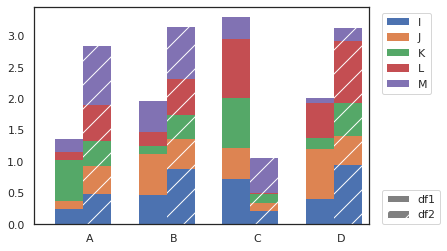

In [6]:
# https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars-with-python-pandas

def plot_clustered_stacked(dfall, labels=None, title="",  H="/", **kwargs):
    """
    Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
    labels is a list of the names of the dataframe, used for the legend
    title is a string for the title of the plot
    H is the hatch used for identification of the different dataframe
    """

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.04, 0.6])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.04, 0.0]) 
    axe.add_artist(l1)
    return axe

# create fake dataframes
df1 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"],
                   columns=["I", "J", "K", "L", "M"])
df2 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"],
                   columns=["I", "J", "K", "L", "M"])
# df3 = pd.DataFrame(np.random.rand(4, 5),
#                    index=["A", "B", "C", "D"], 
#                    columns=["I", "J", "K", "L", "M"])

# exmample call
plot_clustered_stacked([df1, df2],["df1", "df2"])    